# Rotating MNIST with Mixed Digits

# 0. Imports

In [1]:
from typing import Sequence
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev, vmap, jit
from jax.lax import scan, cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn
from flax.training import train_state
from tqdm import trange
import optax
from bayes_opt import BayesianOptimization

from rebayes.utils.utils import MLP, get_mlp_flattened_params
from rebayes.utils import datasets
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import EKFIntegrals, conditional_moments_gaussian_filter
from rebayes.orthogonal_recursive_filter.orfit import RebayesORFit
from rebayes.orthogonal_recursive_filter.orfit_inference import ORFitParams
from rebayes.base import RebayesParams

2023-02-12 12:26:34.710177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-12 12:26:35.380020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-12 12:26:35.380134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-12 12:26:35.380144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use

In [42]:
def plot_results(ax, result_dict, title, legend_loc=None):
    for key, val in result_dict.items():
        ax.plot(val['rmse'], color=val['color'], ls=val['ls'], label=key)
        ax.fill_between(
            jnp.arange(val['rmse'].shape[0]),
            val['rmse'] - 10*val['rmse_std'],
            val['rmse'] + 10*val['rmse_std'],
            alpha=0.1, color=val['color']
        )

    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    ax.grid()
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 150)
    ax.set_xlabel('Training Steps (samples)')
    ax.set_ylabel('RMSE (deg)')
    ax.set_title(title)

    return ax

In [33]:
@partial(jit, static_argnums=(0,))
def compute_orfit_ppd_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

# 1. Load Dataset

In [4]:
# Load rotated MNIST dataset
np.random.seed(314)
num_train = 2_000
num_test = 2_000

train, test = datasets.load_rotated_mnist()
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

idx = jr.choice(jr.PRNGKey(0), X_train.shape[0], shape=(num_train,), replace=False)
# X_train = jnp.array(X_train)[:num_train]
# y_train = jnp.array(y_train)[:num_train]
X_train = jnp.array(X_train)[idx]
y_train = jnp.array(y_train)[idx]

test_idx = jr.choice(jr.PRNGKey(0), X_test.shape[0], shape=(num_test,), replace=False)
X_test = jnp.array(X_test)[test_idx]
y_test = jnp.array(y_test)[test_idx]

ix_sort = jnp.argsort(y_train)
X_train_inc = X_train[ix_sort]
y_train_inc = y_train[ix_sort]

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train_inc = (X_train_inc - X_train_inc.mean()) / X_train_inc.std()

# 2. LoFi Helper Functions

In [18]:
def orfit_experiment(model_dims, key, memory_size, init_cov=None, dynamics_weights=None, emission_cov=None, method='orfit'):
    # Random initialization
    _, params, _, apply_fn = get_mlp_flattened_params(model_dims, key=key)
    model_params = RebayesParams(
        initial_mean=params,
        initial_covariance=init_cov,
        dynamics_weights=dynamics_weights,
        dynamics_covariance=None,
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: emission_cov,
    )
    orfit_params = ORFitParams(
        memory_size=memory_size,
        sv_threshold=0.0
    )
    estimator = RebayesORFit(model_params, orfit_params, method=method)

    train_rmses, test_rmses = [], []

    bel = estimator.init_bel()
    for i in trange(X_train_inc.shape[0]):
        # Update params
        bel = estimator.predict_state(bel)
        bel = estimator.update_state(bel, X_train_inc[i], y_train_inc[i])

        # Train RMSE
        y_train_pred = vmap(jit(apply_fn), (None, 0))(bel.mean, X_train_inc).squeeze()
        train_rmse = jnp.sqrt(((y_train_pred - y_train_inc)**2).mean())
        train_rmses.append(train_rmse)

        # Test RMSE
        y_test_pred = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
        test_rmse = jnp.sqrt(((y_test_pred - y_test)**2).mean())
        test_rmses.append(test_rmse)
    
    return jnp.array(train_rmses), jnp.array(test_rmses)

# 3. Experiments

## 3.1 ORFit-Linear (Memory Size 50)

In [21]:
# Define Linear Regression as single layer perceptron
input_dim, hidden_dims, output_dim = 784, [], 1
model_dims_lr = [input_dim, *hidden_dims, output_dim]

# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
curr_experiment = lambda key: orfit_experiment(model_dims_lr, key, 50)
orfit_train_rmses, orfit_test_rmses = vmap(curr_experiment)(keys)

# Compute mean and std over 10 iterations
orfit_train_rmse, orfit_train_std = orfit_train_rmses.mean(axis=0), orfit_train_rmses.std(axis=0)
orfit_test_rmse, orfit_test_std = orfit_test_rmses.mean(axis=0), orfit_test_rmses.std(axis=0)

100%|██████████| 2000/2000 [00:20<00:00, 97.24it/s] 


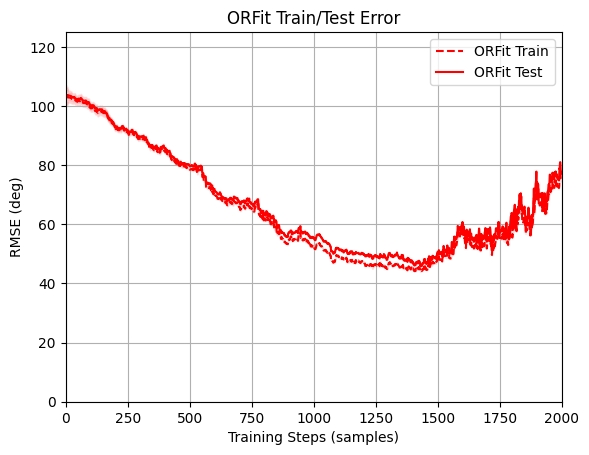

In [34]:
fig, ax = plt.subplots()
orfit_result_dict = {
    'ORFit Train': {
        'rmse': orfit_train_rmse,
        'rmse_std': orfit_train_std,
        'color': 'r',
        'ls': '--',
    },
    'ORFit Test': {
        'rmse': orfit_test_rmse,
        'rmse_std': orfit_test_std,
        'color': 'r',
        'ls': '-',
    }
}
ax = plot_results(ax, orfit_result_dict, 'ORFit Train/Test Error', legend_loc=1)

## 3.2 ORFit-Non Linear

In [23]:
# Define Non Linear Model
model_dims_nl = [784, 100, 100, 1]

# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
curr_experiment = lambda key: orfit_experiment(model_dims_nl, key, 50)
nl_orfit_train_rmses, nl_orfit_test_rmses = vmap(curr_experiment)(keys)

# Compute mean and std over 10 iterations
nl_orfit_train_rmse, nl_orfit_train_std = nl_orfit_train_rmses.mean(axis=0), nl_orfit_train_rmses.std(axis=0)
nl_orfit_test_rmse, nl_orfit_test_std = nl_orfit_test_rmses.mean(axis=0), nl_orfit_test_rmses.std(axis=0)

100%|██████████| 2000/2000 [00:27<00:00, 72.07it/s] 


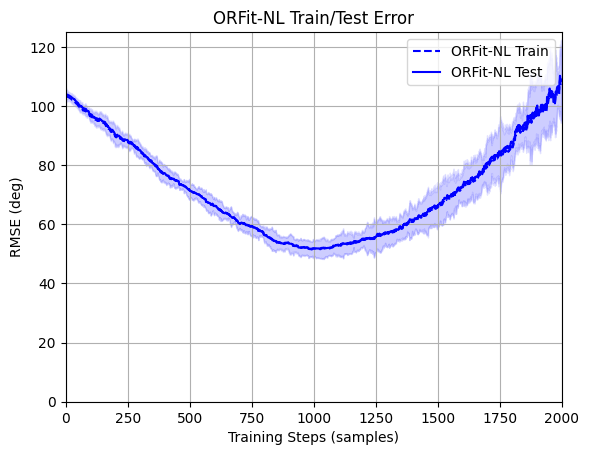

In [35]:
fig, ax = plt.subplots()
nl_orfit_result_dict = {
    'ORFit-NL Train': {
        'rmse': nl_orfit_train_rmse,
        'rmse_std': nl_orfit_train_std,
        'color': 'b',
        'ls': '--',
    },
    'ORFit-NL Test': {
        'rmse': nl_orfit_test_rmse,
        'rmse_std': nl_orfit_test_std,
        'color': 'b',
        'ls': '-',
    }
}
ax = plot_results(ax, nl_orfit_result_dict, 'ORFit-NL Train/Test Error', legend_loc=1)

## 3.3 LoFi

### 3.3.1 Hyperparameter Tuning

In [25]:
model_dims_nl = [784, 100, 100, 1]
_, flat_params, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_nl)
apply_fn_rmnist = jit(apply_fn_rmnist)

def bayesian_orfit_opt_fn(log_init_cov, dynamics_weights, log_emission_cov, memory_size, method='generalized_orfit'):
    model_params_linear = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=None,
        emission_mean_function=apply_fn_rmnist,
        emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
    )
    orfit_params_linear = ORFitParams(
        memory_size=memory_size,
        sv_threshold=0.0
    )
    estimator = RebayesORFit(model_params_linear, orfit_params_linear, method=method)

    bel = estimator.init_bel()
    bel, _ = estimator.scan(X_train_inc, y_train_inc)

    # Test RMSE
    y_test_pred = vmap(apply_fn_rmnist, (None, 0))(bel.mean, X_test).squeeze()
    test_rmse = jnp.sqrt(((y_test_pred - y_test)**2).mean())
    if jnp.isnan(test_rmse):
        return -1e3

    return max(-test_rmse, -1e3)

In [48]:
bayesian_orfit_optimizer = BayesianOptimization(
    f=partial(bayesian_orfit_opt_fn, memory_size=50),
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'dynamics_weights': (0.1, 1.0),
        'log_emission_cov': (-7.0, 0.0),
    },
    verbose=0,
)

In [50]:
# bayesian_orfit_optimizer.maximize(
#     init_points=150,
#     n_iter=150,
# )

In [28]:
# 'dynamics_weights': 0.8702147709259291, 'log_emission_cov': -3.4351845654179356, 'log_init_cov': -2.4164538621498117
print(bayesian_orfit_optimizer.max)

{'target': -57.52256393432617, 'params': {'dynamics_weights': 0.8702147709259291, 'log_emission_cov': -3.4351845654179356, 'log_init_cov': -2.4164538621498117}}


### 3.3.2 Results

In [29]:
model_dims_nl = [784, 100, 100, 1]
tuned_params = {
    'init_cov': jnp.power(10, -2.4164538621498117).item(),
    'dynamics_weights': 0.8702147709259291,
    'emission_cov': jnp.power(10, -3.4351845654179356)
}

# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
curr_experiment = lambda key: orfit_experiment(model_dims_nl, key, memory_size=50, **tuned_params, method='generalized_orfit')
lofi_train_rmses, lofi_test_rmses = vmap(curr_experiment)(keys)

# Compute mean and std over 10 iterations
lofi_train_rmse, lofi_train_std = lofi_train_rmses.mean(axis=0), lofi_train_rmses.std(axis=0)
lofi_test_rmse, lofi_test_std = lofi_test_rmses.mean(axis=0), lofi_test_rmses.std(axis=0)

100%|██████████| 2000/2000 [00:39<00:00, 50.41it/s]


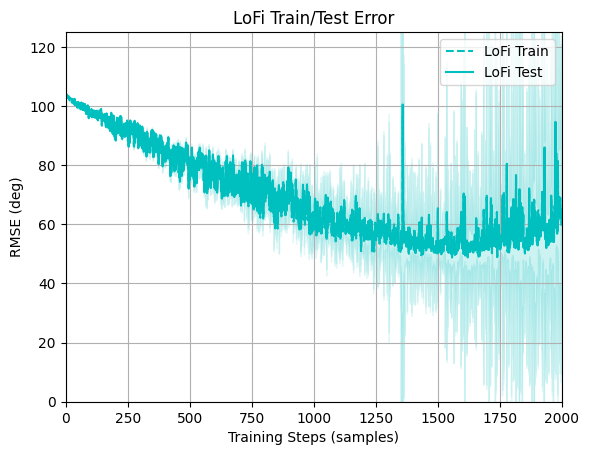

In [37]:
fig, ax = plt.subplots()
lofi_result_dict = {
    'LoFi Train': {
        'rmse': lofi_train_rmse,
        'rmse_std': lofi_train_std,
        'color': 'c',
        'ls': '--',
    },
    'LoFi Test': {
        'rmse': lofi_test_rmse,
        'rmse_std': lofi_test_std,
        'color': 'c',
        'ls': '-',
    }
}
ax = plot_results(ax, lofi_result_dict, 'LoFi Train/Test Error', legend_loc=1)

## 3.4 AOV LoFi

### 3.4.1 Hyperparameter Optimization

In [40]:
aov_lofi_optimizer = BayesianOptimization(
    f=partial(bayesian_orfit_opt_fn, memory_size=50, log_emission_cov=None, method='generalized_orfit_adaptive_obs_var'),
    pbounds={
        'log_init_cov': (-7.0, 0.0),
        'dynamics_weights': (0.1, 1.0),
    }
)

In [41]:
aov_lofi_optimizer.maximize(
    init_points=150,
    n_iter=150,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.24it/s]


| 1         | -59.69    | 0.7918    | -2.888    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.11it/s]


| 2         | -59.36    | 0.7303    | -1.111    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.09it/s]


| 3         | -62.59    | 0.5396    | -0.1456   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.91it/s]


| 4         | -59.11    | 0.7544    | -0.002956 |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 492.07it/s]


| 5         | -104.0    | 0.7535    | -5.585    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.63it/s]


| 6         | -104.0    | 0.2903    | -4.85     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 448.02it/s]


| 7         | -67.16    | 0.9211    | -1.668    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.97it/s]


| 8         | -104.0    | 0.2329    | -6.092    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 479.63it/s]


| 9         | -103.9    | 0.803     | -3.997    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.03it/s]


| 10        | -449.7    | 0.2621    | -1.606    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 472.98it/s]


| 11        | -103.3    | 0.391     | -2.489    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 459.23it/s]


| 12        | -63.73    | 0.8858    | -0.6782   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.29it/s]


| 13        | -104.0    | 0.7168    | -6.308    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 486.61it/s]


| 14        | -104.0    | 0.4144    | -5.064    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.29it/s]


| 15        | -65.2     | 0.3751    | -0.6729   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 495.09it/s]


| 16        | -104.0    | 0.648     | -6.299    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.88it/s]


| 17        | -794.2    | 0.2817    | -1.121    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.85it/s]


| 18        | -103.8    | 0.8272    | -3.772    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 459.95it/s]


| 19        | -59.41    | 0.7733    | -2.366    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.44it/s]


| 20        | -73.25    | 0.9622    | -3.109    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 500.95it/s]


| 21        | -104.0    | 0.611     | -6.933    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.85it/s]


| 22        | -104.0    | 0.3125    | -4.536    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 491.94it/s]


| 23        | -104.0    | 0.5414    | -6.135    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.04it/s]


| 24        | -64.66    | 0.4399    | -1.113    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 491.14it/s]


| 25        | -104.0    | 0.5382    | -5.101    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 446.81it/s]


| 26        | -71.39    | 0.9499    | -0.7455   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.02it/s]


| 27        | -64.78    | 0.4268    | -1.269    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.56it/s]


| 28        | -104.0    | 0.1635    | -4.519    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.83it/s]


| 29        | -104.0    | 0.6521    | -6.305    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 492.65it/s]


| 30        | -104.0    | 0.2486    | -4.76     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 491.94it/s]


| 31        | -104.0    | 0.7236    | -5.394    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.56it/s]


| 32        | -59.52    | 0.7001    | -0.7469   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 504.16it/s]


| 33        | -104.0    | 0.2523    | -6.177    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 491.94it/s]


| 34        | -104.0    | 0.5808    | -5.632    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 503.50it/s]


| 35        | -104.0    | 0.3631    | -6.654    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.58it/s]


| 36        | -103.8    | 0.8759    | -3.903    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 491.53it/s]


| 37        | -104.0    | 0.7833    | -5.761    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.95it/s]


| 38        | -61.29    | 0.5771    | -2.368    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 489.89it/s]


| 39        | -104.0    | 0.6491    | -4.734    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 509.57it/s]


| 40        | -104.0    | 0.5408    | -6.981    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 486.23it/s]


| 41        | -103.9    | 0.1035    | -3.537    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.26it/s]


| 42        | -65.04    | 0.399     | -0.5754   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.72it/s]


| 43        | -104.0    | 0.7523    | -6.974    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.57it/s]


| 44        | -59.63    | 0.7806    | -2.626    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 478.62it/s]


| 45        | -103.8    | 0.3743    | -3.2      |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.12it/s]


| 46        | -104.0    | 0.7636    | -4.626    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.41it/s]


| 47        | -103.4    | 0.4758    | -2.672    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 485.48it/s]


| 48        | -104.0    | 0.3994    | -4.054    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 472.22it/s]


| 49        | -103.5    | 0.5062    | -2.757    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 490.83it/s]


| 50        | -104.0    | 0.6303    | -5.482    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.99it/s]


| 51        | -65.97    | 0.4638    | -1.839    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 451.46it/s]


| 52        | -65.01    | 0.9021    | -2.17     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 497.70it/s]


| 53        | -104.0    | 0.4037    | -6.007    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.79it/s]


| 54        | -104.0    | 0.3167    | -4.914    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 488.23it/s]


| 55        | -104.0    | 0.4146    | -4.722    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.50it/s]


| 56        | -103.9    | 0.4519    | -4.045    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 490.44it/s]


| 57        | -104.0    | 0.3117    | -5.022    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.98it/s]


| 58        | -59.53    | 0.6848    | -2.109    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.24it/s]


| 59        | -64.8     | 0.4398    | -1.201    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 484.03it/s]


| 60        | -104.0    | 0.61      | -4.934    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 456.66it/s]


| 61        | -59.95    | 0.8062    | -0.9641   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 485.55it/s]


| 62        | -104.0    | 0.2692    | -4.361    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.97it/s]


| 63        | -104.0    | 0.2427    | -5.66     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.63it/s]


| 64        | -104.0    | 0.4775    | -6.624    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 495.11it/s]


| 65        | -104.0    | 0.367     | -5.687    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 454.70it/s]


| 66        | -65.14    | 0.9109    | -2.415    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 492.75it/s]


| 67        | -104.0    | 0.4241    | -5.2      |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.89it/s]


| 68        | -102.0    | 0.3343    | -2.032    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 495.10it/s]


| 69        | -104.0    | 0.2896    | -5.786    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 472.87it/s]


| 70        | -103.6    | 0.3413    | -2.807    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.96it/s]


| 71        | -104.0    | 0.8143    | -4.734    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.32it/s]


| 72        | -60.66    | 0.6074    | -1.527    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.21it/s]


| 73        | -103.9    | 0.421     | -3.72     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 488.91it/s]


| 74        | -104.0    | 0.4386    | -4.254    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.68it/s]


| 75        | -69.59    | 0.2005    | -1.242    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 492.93it/s]


| 76        | -104.0    | 0.6868    | -6.259    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 479.07it/s]


| 77        | -103.9    | 0.6524    | -4.147    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.60it/s]


| 78        | -103.9    | 0.1056    | -3.272    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 440.68it/s]


| 79        | -78.72    | 0.9783    | -3.118    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 496.60it/s]


| 80        | -104.0    | 0.3591    | -5.16     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 481.31it/s]


| 81        | -103.9    | 0.7425    | -4.076    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 476.93it/s]


| 82        | -103.6    | 0.4091    | -2.72     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 481.04it/s]


| 83        | -103.9    | 0.5583    | -3.79     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 499.21it/s]


| 84        | -104.0    | 0.3748    | -5.949    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.88it/s]


| 85        | -104.0    | 0.4473    | -4.49     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.58it/s]


| 86        | -59.64    | 0.6799    | -1.309    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 485.69it/s]


| 87        | -103.9    | 0.7423    | -4.034    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.38it/s]


| 88        | -104.0    | 0.7239    | -4.735    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.27it/s]


| 89        | -104.0    | 0.5018    | -4.659    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.14it/s]


| 90        | -472.9    | 0.3145    | -0.3706   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 474.05it/s]


| 91        | -103.5    | 0.8729    | -3.42     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.73it/s]


| 92        | -104.0    | 0.5561    | -5.65     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.30it/s]


| 93        | -59.88    | 0.6593    | -0.3332   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 496.03it/s]


| 94        | -104.0    | 0.7074    | -6.907    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 476.33it/s]


| 95        | -103.8    | 0.8741    | -3.693    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 481.52it/s]


| 96        | -72.46    | 0.9562    | -3.214    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.25it/s]


| 97        | -103.9    | 0.9478    | -4.932    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.39it/s]


| 98        | -66.37    | 0.9142    | -0.06407  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 453.79it/s]


| 99        | -64.74    | 0.8992    | -1.428    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.40it/s]


| 100       | -59.89    | 0.8164    | -0.1583   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.42it/s]


| 101       | -104.0    | 0.1106    | -4.689    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.29it/s]


| 102       | -103.9    | 0.1722    | -3.396    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.18it/s]


| 103       | -60.01    | 0.8084    | -2.747    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.04it/s]


| 104       | -103.8    | 0.1026    | -2.944    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.31it/s]


| 105       | -68.99    | 0.1099    | -0.5865   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.26it/s]


| 106       | -104.0    | 0.2188    | -4.026    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 479.80it/s]


| 107       | -103.9    | 0.5193    | -3.414    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.31it/s]


| 108       | -104.0    | 0.2209    | -5.632    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 485.29it/s]


| 109       | -104.0    | 0.5675    | -5.046    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 448.53it/s]


| 110       | -64.69    | 0.8979    | -2.433    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.17it/s]


| 111       | -59.4     | 0.6985    | -0.05022  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 412.52it/s]


| 112       | -107.7    | 0.9994    | -2.509    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.92it/s]


| 113       | -60.29    | 0.6311    | -1.314    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 451.66it/s]


| 114       | -64.77    | 0.899     | -1.776    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.72it/s]


| 115       | -98.97    | 0.1183    | -1.525    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 437.76it/s]


| 116       | -75.19    | 0.9672    | -1.379    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.35it/s]


| 117       | -104.0    | 0.1014    | -5.043    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 497.06it/s]


| 118       | -104.0    | 0.4989    | -5.248    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.02it/s]


| 119       | -104.0    | 0.6492    | -4.321    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.38it/s]


| 120       | -104.0    | 0.6888    | -6.314    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.74it/s]


| 121       | -59.77    | 0.7978    | -0.4724   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 479.81it/s]


| 122       | -103.9    | 0.5827    | -3.619    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 490.04it/s]


| 123       | -104.0    | 0.783     | -5.602    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.21it/s]


| 124       | -62.88    | 0.5347    | -1.962    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 474.42it/s]


| 125       | -103.7    | 0.7787    | -3.346    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.82it/s]


| 126       | -104.0    | 0.887     | -6.6      |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 473.80it/s]


| 127       | -75.84    | 0.3698    | -2.052    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 499.37it/s]


| 128       | -104.0    | 0.1873    | -4.937    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 497.12it/s]


| 129       | -104.0    | 0.7067    | -6.728    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.24it/s]


| 130       | -65.59    | 0.3586    | -1.262    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 481.44it/s]


| 131       | -103.9    | 0.8499    | -3.992    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.54it/s]


| 132       | -381.0    | 0.335     | -0.3722   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.62it/s]


| 133       | -104.0    | 0.6948    | -5.049    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 474.88it/s]


| 134       | -103.7    | 0.4348    | -3.049    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 487.37it/s]


| 135       | -104.0    | 0.7678    | -4.839    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.86it/s]


| 136       | -59.64    | 0.7918    | -1.746    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.25it/s]


| 137       | -61.8     | 0.5669    | -0.1585   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 476.09it/s]


| 138       | -103.7    | 0.2349    | -2.888    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 456.61it/s]


| 139       | -61.42    | 0.8601    | -2.877    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 490.49it/s]


| 140       | -104.0    | 0.3345    | -4.622    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.09it/s]


| 141       | -103.6    | 0.1368    | -2.723    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 477.16it/s]


| 142       | -103.8    | 0.7903    | -3.636    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.74it/s]


| 143       | -90.53    | 0.1309    | -0.5229   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.67it/s]


| 144       | -62.38    | 0.5432    | -0.4835   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.96it/s]


| 145       | -104.0    | 0.2105    | -5.114    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.69it/s]


| 146       | -104.0    | 0.247     | -4.572    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 502.47it/s]


| 147       | -104.0    | 0.31      | -6.754    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 443.26it/s]


| 148       | -71.39    | 0.9504    | -2.583    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.86it/s]


| 149       | -100.9    | 0.1468    | -0.477    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.99it/s]


| 150       | -98.05    | 0.1151    | -1.448    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.71it/s]


| 151       | -62.04    | 0.5568    | -1.132    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.54it/s]


| 152       | -90.27    | 0.185     | -1.328    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.13it/s]


| 153       | -59.37    | 0.7188    | -0.5946   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.08it/s]


| 154       | -59.98    | 0.8108    | -2.745    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.06it/s]


| 155       | -1e+03    | 0.1792    | -0.3664   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 464.87it/s]


| 156       | -62.24    | 0.549     | -0.6568   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.70it/s]


| 157       | -103.7    | 0.2698    | -2.837    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.49it/s]


| 158       | -68.71    | 0.1244    | -0.7751   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 457.60it/s]


| 159       | -65.86    | 0.9144    | -0.06319  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 471.64it/s]


| 160       | -68.73    | 0.1245    | -0.7748   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 476.46it/s]


| 161       | -63.93    | 0.52      | -2.191    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.70it/s]


| 162       | -61.03    | 0.5948    | -0.9472   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.39it/s]


| 163       | -59.48    | 0.7657    | -1.563    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.09it/s]


| 164       | -59.42    | 0.7219    | -1.932    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.08it/s]


| 165       | -60.37    | 0.6225    | -1.724    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 451.17it/s]


| 166       | -63.66    | 0.8903    | -1.986    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.17it/s]


| 167       | -59.7     | 0.6697    | -2.499    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 457.74it/s]


| 168       | -62.48    | 0.8721    | -1.196    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.43it/s]


| 169       | -61.87    | 0.862     | -0.3121   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 442.25it/s]


| 170       | -74.3     | 0.9625    | -1.049    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 440.97it/s]


| 171       | -77.43    | 0.9803    | -0.5015   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.80it/s]


| 172       | -103.5    | 0.7701    | -3.075    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.13it/s]


| 173       | -63.83    | 0.5006    | -0.8013   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.10it/s]


| 174       | -102.6    | 0.3598    | -2.24     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.67it/s]


| 175       | -59.48    | 0.6944    | -2.253    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 413.53it/s]


| 176       | -104.9    | 0.9987    | -2.779    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.93it/s]


| 177       | -103.9    | 0.4754    | -3.797    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.17it/s]


| 178       | -59.42    | 0.7297    | -1.443    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.43it/s]


| 179       | -61.84    | 0.5594    | -0.003509 |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 459.50it/s]


| 180       | -60.79    | 0.8367    | -0.8151   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.53it/s]


| 181       | -65.11    | 0.3823    | -0.01177  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 504.83it/s]


| 182       | -103.8    | 0.9993    | -6.062    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.02it/s]


| 183       | -104.0    | 0.1       | -7.0      |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 431.26it/s]


| 184       | -90.9     | 0.9959    | -4.332    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.03it/s]


| 185       | -104.0    | 0.1       | -6.471    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 509.76it/s]


| 186       | -103.9    | 0.9878    | -5.231    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.94it/s]


| 187       | -59.33    | 0.7665    | -0.3812   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 504.17it/s]


| 188       | -104.0    | 0.1       | -5.37     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 511.07it/s]


| 189       | -104.0    | 0.9973    | -6.868    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 479.98it/s]


| 190       | -103.4    | 0.1044    | -2.467    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 440.36it/s]


| 191       | -76.48    | 0.9733    | -0.8998   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.24it/s]


| 192       | -64.92    | 0.4886    | -1.79     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.26it/s]


| 193       | -104.0    | 0.9976    | -6.369    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 488.14it/s]


| 194       | -103.9    | 0.1062    | -3.792    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 506.83it/s]


| 195       | -103.6    | 0.9893    | -4.529    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 492.74it/s]


| 196       | -104.0    | 0.6814    | -6.396    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 424.12it/s]


| 197       | -95.49    | 0.9963    | -1.536    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.43it/s]


| 198       | -104.0    | 0.4557    | -5.253    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 505.39it/s]


| 199       | -104.0    | 0.3784    | -6.386    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 438.89it/s]


| 200       | -114.0    | 0.9999    | -5.466    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.16it/s]


| 201       | -60.39    | 0.6203    | -1.85     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 494.68it/s]


| 202       | -104.0    | 0.7502    | -5.999    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 428.34it/s]


| 203       | -104.8    | 0.9992    | -0.3221   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.42it/s]


| 204       | -104.0    | 0.9892    | -5.795    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 419.86it/s]


| 205       | -98.89    | 0.9975    | -1.892    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 475.67it/s]


| 206       | -102.9    | 0.1043    | -2.202    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 493.63it/s]


| 207       | -104.0    | 0.1038    | -4.212    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 510.93it/s]


| 208       | -104.0    | 0.1       | -6.724    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 508.93it/s]


| 209       | -104.0    | 0.1011    | -5.89     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 477.80it/s]


| 210       | -103.9    | 0.5965    | -3.604    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 415.73it/s]


| 211       | -112.6    | 1.0       | -4.138    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.57it/s]


| 212       | -59.36    | 0.7194    | -0.2172   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 480.98it/s]


| 213       | -103.5    | 0.6208    | -2.922    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 413.20it/s]


| 214       | -109.9    | 0.9998    | -2.069    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.12it/s]


| 215       | -586.7    | 0.1012    | -1.247    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 499.21it/s]


| 216       | -104.0    | 0.711     | -6.264    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.12it/s]


| 217       | -1e+03    | 0.2663    | -1.308    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.03it/s]


| 218       | -59.68    | 0.6758    | -2.387    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.15it/s]


| 219       | -59.36    | 0.7682    | -0.2863   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.04it/s]


| 220       | -59.41    | 0.7155    | -1.818    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.04it/s]


| 221       | -59.56    | 0.7799    | -0.6857   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.47it/s]


| 222       | -59.95    | 0.8077    | -1.863    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.78it/s]


| 223       | -59.99    | 0.6482    | -0.6613   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 464.01it/s]


| 224       | -61.06    | 0.5939    | -0.7534   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.45it/s]


| 225       | -60.72    | 0.8339    | -1.078    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.11it/s]


| 226       | -59.34    | 0.7668    | -2.469    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.29it/s]


| 227       | -59.46    | 0.6943    | -0.4592   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.93it/s]


| 228       | -60.61    | 0.6133    | -0.5548   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.22it/s]


| 229       | -59.57    | 0.6971    | -0.9962   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.21it/s]


| 230       | -59.43    | 0.7187    | -0.885    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.27it/s]


| 231       | -61.2     | 0.5869    | -2.261    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.21it/s]


| 232       | -60.42    | 0.6213    | -0.862    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.70it/s]


| 233       | -59.71    | 0.6807    | -1.622    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.73it/s]


| 234       | -60.49    | 0.6146    | -2.169    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 482.27it/s]


| 235       | -104.0    | 0.6888    | -4.425    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 461.67it/s]


| 236       | -60.33    | 0.6301    | -1.42     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.10it/s]


| 237       | -60.24    | 0.6337    | -1.996    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.63it/s]


| 238       | -62.37    | 0.5486    | -2.076    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 457.75it/s]


| 239       | -60.12    | 0.8169    | -1.641    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.47it/s]


| 240       | -60.49    | 0.827     | -0.5813   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.92it/s]


| 241       | -59.54    | 0.7751    | -2.028    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 423.93it/s]


| 242       | -82.3     | 0.9878    | -3.331    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 460.46it/s]


| 243       | -59.6     | 0.787     | -2.165    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 455.99it/s]


| 244       | -60.56    | 0.8313    | -2.265    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.29it/s]


| 245       | -59.9     | 0.6579    | -1.191    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 424.46it/s]


| 246       | -81.72    | 0.9872    | -3.331    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.94it/s]


| 247       | -59.43    | 0.7658    | -1.211    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 459.50it/s]


| 248       | -59.82    | 0.8004    | -1.338    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 498.25it/s]


| 249       | -104.0    | 0.6124    | -6.748    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.13it/s]


| 250       | -63.51    | 0.5141    | -1.046    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.54it/s]


| 251       | -60.56    | 0.6165    | -1.058    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 452.87it/s]


| 252       | -61.26    | 0.8511    | -2.537    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 453.69it/s]


| 253       | -62.53    | 0.8719    | -1.549    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.80it/s]


| 254       | -62.03    | 0.558     | -1.629    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 459.90it/s]


| 255       | -63.08    | 0.8777    | -0.412    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 475.76it/s]


| 256       | -103.4    | 0.1683    | -2.539    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 455.11it/s]


| 257       | -61.59    | 0.857     | -2.083    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.49it/s]


| 258       | -63.87    | 0.4988    | -0.5732   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 464.62it/s]


| 259       | -63.77    | 0.504     | -0.9097   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 453.07it/s]


| 260       | -65.83    | 0.9077    | -1.292    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.84it/s]


| 261       | -59.64    | 0.6635    | -2.62     |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.08it/s]


| 262       | -59.19    | 0.7019    | -2.712    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 472.73it/s]


| 263       | -61.18    | 0.5714    | -2.482    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.39it/s]


| 264       | -61.74    | 0.5618    | -0.268    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.57it/s]


| 265       | -61.57    | 0.5702    | -0.3815   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 469.30it/s]


| 266       | -63.4     | 0.4632    | -0.05986  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 499.05it/s]


| 267       | -104.0    | 0.2126    | -5.274    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 443.71it/s]


| 268       | -69.68    | 0.9419    | -2.279    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 432.23it/s]


| 269       | -82.48    | 0.9869    | -1.202    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.55it/s]


| 270       | -64.45    | 0.47      | -0.6967   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.05it/s]


| 271       | -67.53    | 0.4849    | -2.306    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.06it/s]


| 272       | -65.19    | 0.3814    | -0.7859   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.47it/s]


| 273       | -859.4    | 0.2711    | -0.7406   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 467.98it/s]


| 274       | -64.57    | 0.423     | -0.8611   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 435.30it/s]


| 275       | -74.87    | 0.9654    | -2.664    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 425.63it/s]


| 276       | -106.3    | 0.9992    | -0.631    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 454.97it/s]


| 277       | -64.07    | 0.9057    | -2.972    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 464.79it/s]


| 278       | -63.98    | 0.5056    | -1.472    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 463.78it/s]


| 279       | -63.36    | 0.5185    | -1.358    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 462.82it/s]


| 280       | -61.88    | 0.5611    | -1.243    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:03<00:00, 509.43it/s]


| 281       | -103.9    | 0.9628    | -4.537    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.64it/s]


| 282       | -64.84    | 0.3649    | -0.131    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.88it/s]


| 283       | -770.6    | 0.2717    | -0.05574  |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.60it/s]


| 284       | -64.14    | 0.434     | -0.1796   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.56it/s]


| 285       | -103.2    | 0.6934    | -2.817    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.39it/s]


| 286       | -67.45    | 0.4348    | -1.955    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 411.13it/s]


| 287       | -105.7    | 1.0       | 0.0       |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 477.39it/s]


| 288       | -103.7    | 0.8074    | -3.103    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 471.88it/s]


| 289       | -73.71    | 0.1354    | -0.7367   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.63it/s]


| 290       | -68.5     | 0.3407    | -1.861    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 458.83it/s]


| 291       | -65.96    | 0.908     | -0.2193   |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 418.73it/s]


| 292       | -88.01    | 0.9936    | -2.929    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 466.59it/s]


| 293       | -101.5    | 0.2031    | -1.877    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 472.79it/s]


| 294       | -103.2    | 0.5686    | -2.588    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 468.84it/s]


| 295       | -67.62    | 0.4603    | -2.102    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 464.69it/s]


| 296       | -65.38    | 0.4664    | -1.682    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 470.98it/s]


| 297       | -103.1    | 0.4849    | -2.417    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 471.42it/s]


| 298       | -103.8    | 0.8738    | -3.274    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 414.27it/s]


| 299       | -110.4    | 1.0       | -3.489    |


Running for 2,000 iterations: 100%|██████████| 2000/2000 [00:04<00:00, 465.08it/s]

| 300       | -64.76    | 0.4826    | -1.563    |


In [43]:
print(aov_lofi_optimizer.max)

{'target': -59.11098861694336, 'params': {'dynamics_weights': 0.7543918061606835, 'log_init_cov': -0.002955875086337656}}


### 3.4.2 Results

In [44]:
model_dims_nl = [784, 100, 100, 1]
tuned_params = {
    'init_cov': jnp.power(10, -0.002955875086337656).item(),
    'dynamics_weights': 0.7543918061606835,
}

# Run 10 Iterations
keys = jr.split(jr.PRNGKey(0), 10)
curr_experiment = lambda key: orfit_experiment(model_dims_nl, key, memory_size=50, **tuned_params, method='generalized_orfit_adaptive_obs_var')
aov_lofi_train_rmses, aov_lofi_test_rmses = vmap(curr_experiment)(keys)

# Compute mean and std over 10 iterations
aov_lofi_train_rmse, aov_lofi_train_std = aov_lofi_train_rmses.mean(axis=0), aov_lofi_train_rmses.std(axis=0)
aov_lofi_test_rmse, aov_lofi_test_std = aov_lofi_test_rmses.mean(axis=0), aov_lofi_test_rmses.std(axis=0)

100%|██████████| 2000/2000 [00:55<00:00, 35.78it/s]


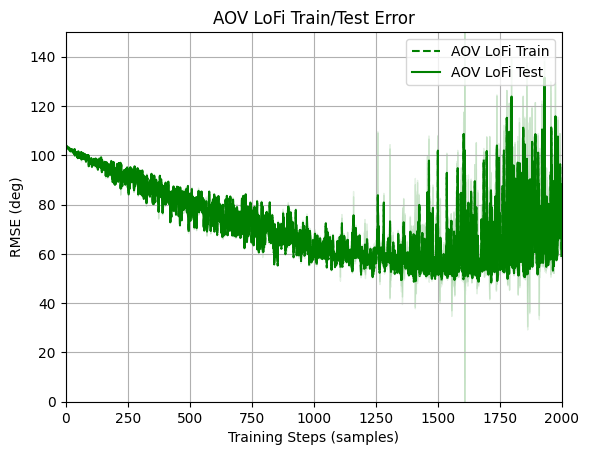

In [45]:
fig, ax = plt.subplots()
aov_lofi_result_dict = {
    'AOV LoFi Train': {
        'rmse': aov_lofi_train_rmse,
        'rmse_std': aov_lofi_train_std,
        'color': 'g',
        'ls': '--',
    },
    'AOV LoFi Test': {
        'rmse': aov_lofi_test_rmse,
        'rmse_std': aov_lofi_test_std,
        'color': 'g',
        'ls': '-',
    }
}
ax = plot_results(ax, aov_lofi_result_dict, 'AOV LoFi Train/Test Error', legend_loc=1)

## 3.5 Model Comparison

In [46]:
model_comparison_dict = {
    **orfit_result_dict,
    **nl_orfit_result_dict,
    **lofi_result_dict,
    **aov_lofi_result_dict,
}

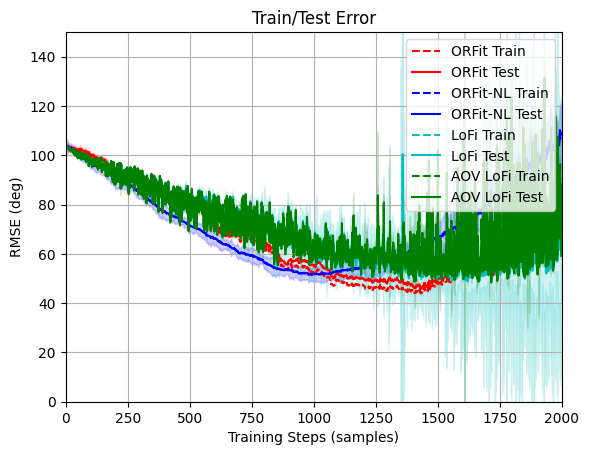

In [47]:
fig, ax = plt.subplots()
ax = plot_results(ax, model_comparison_dict, 'Train/Test Error', legend_loc=1)